In [1]:
!pip install keras_nlp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers,models
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import keras_nlp
import keras
from keras import layers

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
DF_Train = pd.read_csv("/kaggle/input/datatrain/train_essays.csv")
DF_Train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [5]:
prompts = pd.read_csv("/kaggle/input/datatrain/train_prompts.csv")
prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [6]:
DF_Test = pd.read_csv("/kaggle/input/datatrain/test_essays.csv")
DF_Test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [7]:
DF_Train.isnull().values.any()

False

In [8]:
DF_Train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

<Axes: xlabel='generated'>

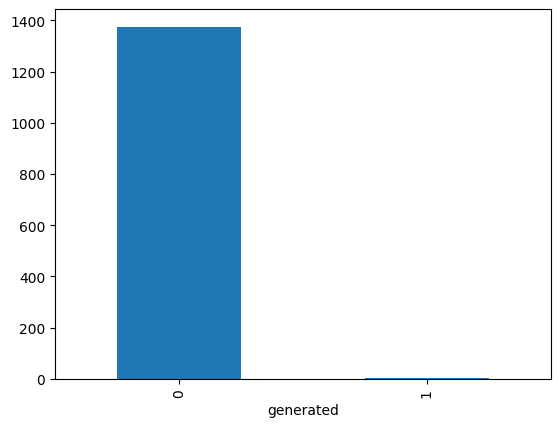

In [9]:
DF_Train.generated.value_counts().plot.bar()

In [10]:
textos_generados = pd.read_csv("/kaggle/input/datatrain/ai_generated_train_essays.csv")
textos_generados

,id,prompt_id,text,generated
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1
3,f2266d87,0,The passages provided discuss the advantages o...,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1
...,...,...,...,...
495,c67009a2,1,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1
496,66e830cc,1,"[Your Name]\n[Your Address]\n[City, State, Zip...",1
497,5d70a380,1,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1
498,9a07aa27,1,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1


In [11]:
data = pd.concat([textos_generados, DF_Train], ignore_index=True)
data

,id,prompt_id,text,generated
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1
3,f2266d87,0,The passages provided discuss the advantages o...,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1
...,...,...,...,...
1873,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1874,ff669174,0,Limiting car usage has many advantages. Such a...,0
1875,ffa247e0,0,There's a new trend that has been developing f...,0
1876,ffc237e9,0,As we all know cars are a big part of our soci...,0


<Axes: xlabel='generated'>

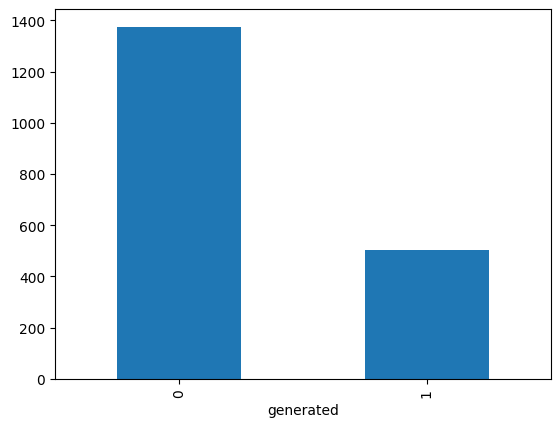

In [12]:
data.generated.value_counts().plot.bar()

In [13]:
New_Data = pd.read_csv("/kaggle/input/datatrain/train_v2_drcat_02.csv")
New_Data

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [14]:
New_Data.rename(columns = {"label": "generated"}, inplace = True)

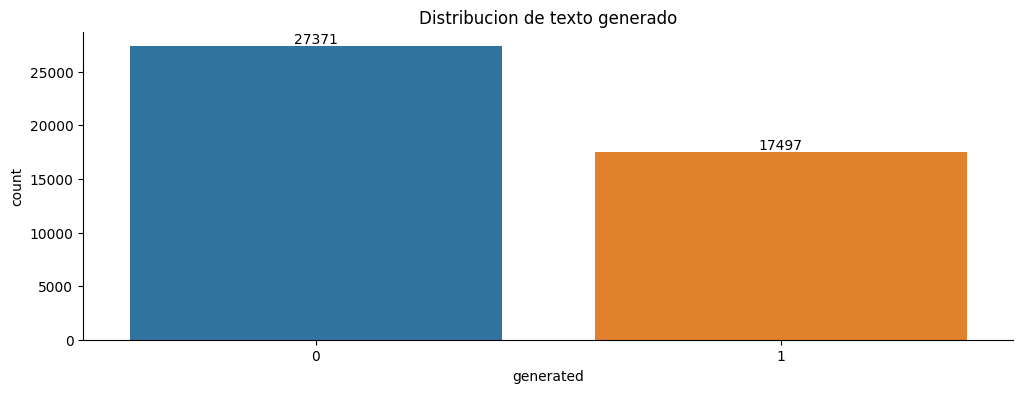

In [15]:
def plot_text_dist(New_Data):
  f, ax = plt.subplots(figsize=(12, 4))

  sns.despine()
  ax = sns.countplot(data=New_Data,
                    x="generated")

  abs_values = New_Data['generated'].value_counts().values

  ax.bar_label(container=ax.containers[0], labels=abs_values)

  ax.set_title("Distribucion de texto generado")
plot_text_dist(New_Data)

In [16]:
Data = pd.concat([New_Data[["text", "generated"]], data[["text", "generated"]]])
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46746 entries, 0 to 1877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46746 non-null  object
 1   generated  46746 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Distribucion de la longitud del texto')

<Figure size 4000x5000 with 0 Axes>

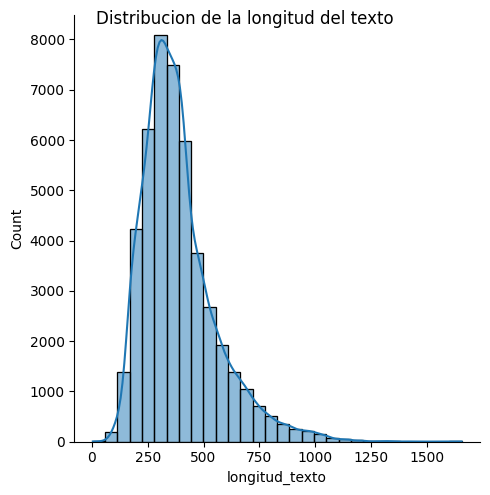

In [17]:
Data["longitud_texto"] = Data["text"].apply(lambda x : len(x.split()))

fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=Data,
                 x="longitud_texto", bins=30, kde=True)
plot.fig.suptitle("Distribucion de la longitud del texto")

In [18]:
import torch
torch.cuda.is_available()

True

In [19]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
torch.__version__

'2.4.0'

In [21]:
Data.loc[Data["longitud_texto"] <= 512]

,text,generated,longitud_texto
0,Phones\n\nModern humans today are always on th...,0,379
1,This essay will explain if drivers should or s...,0,366
2,Driving while the use of cellular devices\n\nT...,0,178
3,Phones & Driving\n\nDrivers should not be able...,0,212
4,Cell Phone Operation While Driving\n\nThe abil...,0,332
...,...,...,...
1869,"Cars are a very big part of our lives, we rely...",0,497
1872,studies have shown that passenger cars are res...,0,426
1873,There has been a fuss about the Elector Colleg...,0,430
1874,Limiting car usage has many advantages. Such a...,0,397


In [22]:
final_data = Data.loc[Data["longitud_texto"] <= 512]

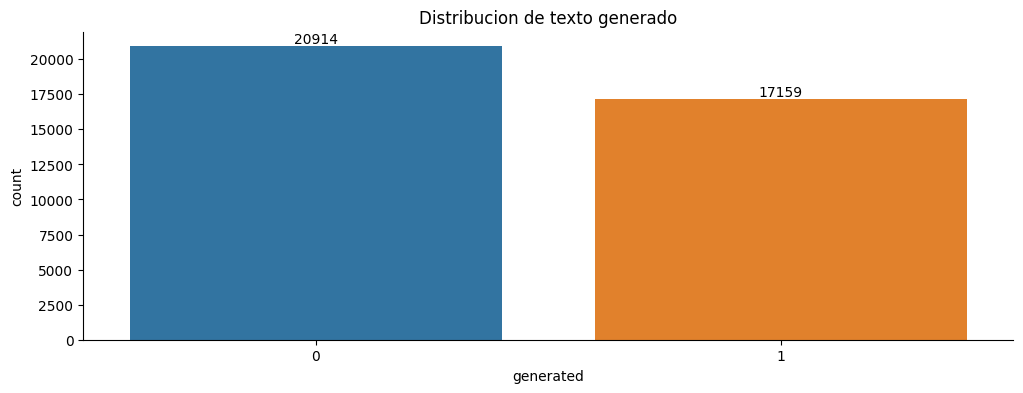

In [23]:
plot_text_dist(final_data)

In [24]:
final_data.drop(columns = ['longitud_texto'], inplace = True)

/tmp/ipykernel_36/2441576816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.drop(columns = ['longitud_texto'], inplace = True)


In [25]:
final_data.index = np.arange(0, final_data.shape[0])
final_data

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
38068,"Cars are a very big part of our lives, we rely...",0
38069,studies have shown that passenger cars are res...,0
38070,There has been a fuss about the Elector Colleg...,0
38071,Limiting car usage has many advantages. Such a...,0


In [26]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:1], final_data['generated'],test_size=0.2)

In [27]:
def scheduler(epoch, lr):
    if epoch == 3:
        return lr * tf.math.exp(-0.1)
    else:
        return lr 

callback = keras.callbacks.LearningRateScheduler(scheduler)

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length = 512
)
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes = 1,
    activation = keras.activations.sigmoid,
    preprocessor=preprocessor
)

classifier.backbone.trainable = False

classifier.compile(
    loss = ['binary_crossentropy'],
    optimizer = keras.optimizers.Adam(1e-4),
    #jit_compile = True,
    metrics = ['accuracy', 'AUC']
)

In [28]:
classifier.summary()

Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,954,241 (255.41 MB)

 Trainable params: 591,361 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

In [29]:
classifier.fit(x= x_train['text'].to_list(),
               y=y_train,
               batch_size = 8,
               epochs =3,
               validation_data = (x_test['text'].to_list(),y_test),
               callbacks = [callback])

Epoch 1/3


I0000 00:00:1727294434.180343     109 service.cc:145] XLA service 0x7c2890004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727294434.180427     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/3808 ━━━━━━━━━━━━━━━━━━━━ 5:11 82ms/step - AUC: 0.9000 - accuracy: 0.3750 - loss: 0.6975   

I0000 00:00:1727294465.648890     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3808/3808 ━━━━━━━━━━━━━━━━━━━━ 415s 99ms/step - AUC: 0.9758 - accuracy: 0.9275 - loss: 0.2026 - val_AUC: 0.9956 - val_accuracy: 0.9078 - val_loss: 0.2333 - learning_rate: 1.0000e-04
Epoch 2/3
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 339s 89ms/step - AUC: 0.9958 - accuracy: 0.9781 - loss: 0.0653 - val_AUC: 0.9925 - val_accuracy: 0.9169 - val_loss: 0.2413 - learning_rate: 1.0000e-04


In [32]:
test = ["hola me llamo miguel sioque, este texto lo escribi yo sioque",
        "Es peligroso y poco recomendable. Manejar requiere atencion y concentracion, y escribir al mismo tiempo puede distraerte y aumentar el riesgo de accidentes. La seguridad siempre debe ser la prioridad",
        "Manejar y escribir esta mal pa"]
preds = classifier.predict(DF_Test["text"].to_list())
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


array([[0.25524998],
       [0.3039735 ],
       [0.7172571 ]], dtype=float32)

In [36]:
classifier.save('/kaggle/working/Modelo1.keras')
